# Marcel Bilski 295472 - kod do pracy magisterskiej, analiza sentymentu przy użyciu NRC Emolex

## Dodanie bibliotek i datasetu

In [ ]:
# Pobranie NRCLex w terminalu
# !pip install NRCLex
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter
from dateutil import parser

import itertools
from itertools import combinations

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

from nrclex import NRCLex

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

stop_words.remove('not')
stop_words.remove('nor')
stop_words.remove('no')

from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

nltk.download('punkt')
nltk.download('punkt_tab')

import string
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Dodanie datasetu i nazwanie kolumn

In [ ]:
# Dodanie nazw kolumn
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
# Dodanie kodowania, alfabet łaciński
DATASET_ENCODING = "ISO-8859-1"
# Podłączenie danych
df = pd.read_csv('drive/MyDrive/training.1600000.processed.noemoticon.csv',
                 encoding = DATASET_ENCODING, names=DATASET_COLUMNS)

df = df[['target','ids','text']]

df.head(10)

,target,ids,text
0,0,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,is upset that he can't update his Facebook by ...
2,0,1467810917,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,my whole body feels itchy and like its on fire
4,0,1467811193,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,@Kwesidei not the whole crew
6,0,1467811592,Need a hug
7,0,1467811594,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,@Tatiana_K nope they didn't have it
9,0,1467812025,@twittera que me muera ?


## Wykres podziału sentymentów w danych

Jak widać w datasecie nie ma żadnych sentymentów neutralnych

<Axes: xlabel='target', ylabel='count'>

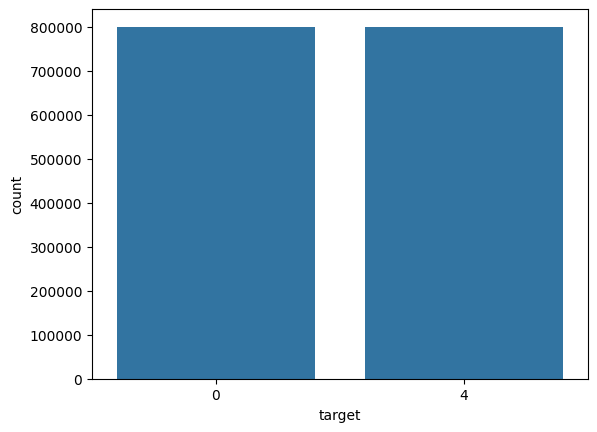

In [ ]:
# Sprawdzenie czy nie ma sentymentów neutralnych
sns.countplot(x = "target", data = df)

## Ograniczenie się do 2000 pozycji, po tysiąć z każdej grupy

In [ ]:
# Wybranie 1000 wierszy z zmienną 0 w target
df_0 = df[df['target'] == 0].head(1000)

# Wybranie 1000 wierszy z zmienną 4 w target
df_4 = df[df['target'] == 4].head(1000)

# Połącz oby zbiorów
df_subset = pd.concat([df_0, df_4])

# Resetowanie indeksu
df_subset = df_subset.reset_index(drop=True)

# Wynik

df_subset = pd.concat([df_0, df_4]).reset_index(drop=True)

df_subset.head(25)

   target         ids                                               text
0       0  1467810369  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  1467810672  is upset that he can't update his Facebook by ...
2       0  1467810917  @Kenichan I dived many times for the ball. Man...
3       0  1467811184    my whole body feels itchy and like its on fire 
4       0  1467811193  @nationwideclass no, it's not behaving at all....


,target,ids,text
0,0,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,is upset that he can't update his Facebook by ...
2,0,1467810917,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,my whole body feels itchy and like its on fire
4,0,1467811193,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,@Kwesidei not the whole crew
6,0,1467811592,Need a hug
7,0,1467811594,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,@Tatiana_K nope they didn't have it
9,0,1467812025,@twittera que me muera ?


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_subset)

https://docs.google.com/spreadsheets/d/1C6ZYUmzxT-liDSk-86YkII5H7GSe6VLxFC0cN2G_KtM/edit#gid=0


## Sprawdzanie emocji w tekstach przed ich wyczyszczeniem

In [ ]:
df_subset['emotions'] = df_subset['text'].apply(lambda x: NRCLex(x).top_emotions)
df_subset.head()

,target,ids,text,emotions
0,0,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[(anger, 0.3333333333333333), (negative, 0.333..."
1,0,1467810672,is upset that he can't update his Facebook by ...,"[(negative, 0.3333333333333333), (sadness, 0.3..."
2,0,1467810917,@Kenichan I dived many times for the ball. Man...,"[(positive, 0.5)]"
3,0,1467811184,my whole body feels itchy and like its on fire,"[(fear, 1.0)]"
4,0,1467811193,"@nationwideclass no, it's not behaving at all....","[(fear, 0.2), (anger, 0.2), (negative, 0.2), (..."


## Ilość pozytywnych i negatywnych sentymentów w tekstach, przed usunięciem stopwordów, tokenizacją i lematyzacją

In [ ]:
# Funkcja, która pozwala ocenić sentyment według NRC
def label_polarity(text):
    emotion_scores = NRCLex(text).raw_emotion_scores
    pos = emotion_scores.get('positive', 0)
    neg = emotion_scores.get('negative', 0)

    if pos > neg:
        return 4  # pozytywny
    elif neg > pos:
        return 0  # negatywny
    else:
        return 2  # neutralny

#  Dodanie funkcji label_polarity do danych
df_subset['nrc_sentiment'] = df_subset['text'].apply(label_polarity)

# wynik
print(df_subset[['text', 'nrc_sentiment']].head(10))

                                                text  nrc_sentiment
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...              0
1  is upset that he can't update his Facebook by ...              0
2  @Kenichan I dived many times for the ball. Man...              4
3    my whole body feels itchy and like its on fire               2
4  @nationwideclass no, it's not behaving at all....              0
5                      @Kwesidei not the whole crew               2
6                                        Need a hug               4
7  @LOLTrish hey  long time no see! Yes.. Rains a...              2
8               @Tatiana_K nope they didn't have it               2
9                          @twittera que me muera ?               2


Sentymentu

Sentyment neutralny został zapisany na podstawie tekstów, gdzie liczba sentymentów poztywnych i negatywnych była równa.

Suma: 0 = negatywny, 2 = neutralny, 4 = pozytywny

In [ ]:
df_subset['nrc_sentiment'].value_counts()

,count
nrc_sentiment,
2,1022
4,572
0,406


## Czyszczenie danych

Zmiana liter na małe, usunięcie linków, usunięcie @ oraz usunięcie znaków interpunkcyjnych

In [ ]:
# Czyszczenie danych
def clean_text(text):
    text = text.lower()  # zmiana na małe litery
    text = re.sub(r'http\S+|www\.\S+', '', text)  # usuń linki
    text = re.sub(r'@', '', text)                 # usuń @
    text = re.sub(r'[^\w\s]', '', text)           # usuń interpunkcję
    return text

df_subset['text'] = df_subset['text'].apply(clean_text)
df_subset['text'].head()

,text
0,switchfoot awww thats bummer shoulda got david...
1,upset cant update facebook texting might cry r...
2,kenichan dived many times ball managed save 50...
3,whole body feels itchy like fire
4,nationwideclass behaving im mad cant see


Stopwords i tokenizacja

In [ ]:
# Załadowanie NLTK stopwords
stop_words = nltk.corpus.stopwords.words('english')

# Dodanie tokenizacji
def detect_emotions(text):
    # Usunięcie słów stopów i tokenizacja
    words = [word for word in nltk.word_tokenize(text) if word.lower() not in stop_words]
    cleaned_text = ' '.join(words)

    return cleaned_text


df_subset['emotions'] = df_subset['text'].apply(detect_emotions)
df_subset.head()

,target,ids,text,emotions,nrc_sentiment
0,0,1467810369,switchfoot awww thats bummer shoulda got david...,switchfoot awww thats bummer shoulda got david...,0
1,0,1467810672,upset cant update facebook texting might cry r...,upset cant update facebook texting might cry r...,0
2,0,1467810917,kenichan dived many times ball managed save 50...,kenichan dived many times ball managed save 50...,4
3,0,1467811184,whole body feels itchy like fire,whole body feels itchy like fire,2
4,0,1467811193,nationwideclass behaving im mad cant see,nationwideclass behaving im mad cant see,0


Lematyzacja

In [ ]:
lemmatizer = WordNetLemmatizer()
# Lematyzacja
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)  # tokenizacja
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]  # lematyzacja każdego tokena
    return ' '.join(lemmas)  # scal z powrotem na string

df_subset['text_lemmatized'] = df_subset['emotions'].apply(lemmatize_text)
df_subset.head()

,target,ids,text,emotions,nrc_sentiment,text_lemmatized
0,0,1467810369,switchfoot awww thats bummer shoulda got david...,switchfoot awww thats bummer shoulda got david...,0,switchfoot awww thats bummer shoulda got david...
1,0,1467810672,upset cant update facebook texting might cry r...,upset cant update facebook texting might cry r...,0,upset cant update facebook texting might cry r...
2,0,1467810917,kenichan dived many times ball managed save 50...,kenichan dived many times ball managed save 50...,4,kenichan dived many time ball managed save 50 ...
3,0,1467811184,whole body feels itchy like fire,whole body feels itchy like fire,2,whole body feel itchy like fire
4,0,1467811193,nationwideclass behaving im mad cant see,nationwideclass behaving im mad cant see,0,nationwideclass behaving im mad cant see


Gotowe dane do analizy NRC

In [ ]:
df_daneNRC = df_subset[['target','ids','text_lemmatized']]
df_daneNRC.head()

,target,ids,text_lemmatized
0,0,1467810369,switchfoot awww thats bummer shoulda got david...
1,0,1467810672,upset cant update facebook texting might cry r...
2,0,1467810917,kenichan dived many time ball managed save 50 ...
3,0,1467811184,whole body feel itchy like fire
4,0,1467811193,nationwideclass behaving im mad cant see


## Ilość pozytywnych i negatywnych sentymentów po oczyszczeniu danych

In [ ]:
# Dodanie funkcji lematyzacji do danych
df_daneNRC['nrc_sentiment'] = df_daneNRC['text_lemmatized'].apply(label_polarity)

# wyniki
print(df_daneNRC[['text_lemmatized', 'nrc_sentiment']].head(10))

                                     text_lemmatized  nrc_sentiment
0  switchfoot awww thats bummer shoulda got david...              0
1  upset cant update facebook texting might cry r...              0
2  kenichan dived many time ball managed save 50 ...              4
3                    whole body feel itchy like fire              2
4           nationwideclass behaving im mad cant see              0
5                                kwesidei whole crew              2
6                                           need hug              4
7  loltrish hey long time see yes rain bit bit lo...              2
8                               tatiana_k nope didnt              2
9                                 twittera que muera              2


/tmp/ipython-input-81-1620910122.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Suma sentymentu

Sentyment neutralny został zapisany na podstawie tekstów, gdzie liczba sentymentów poztywnych i negatywnych była równa.

Suma: 0 = negatywny, 2 = neutralny, 4 = pozytywny

In [ ]:
# Suma sentymentów
df_daneNRC['nrc_sentiment'].value_counts()

,count
nrc_sentiment,
2,928
4,633
0,439


## Diagram kołowy i wykres słupkowy dla frekwencji emocji

Frekwencja emocji

In [ ]:
EmotionDf = NRCLex(' '.join(df_daneNRC['text_lemmatized']))

# stworzenie słownika dla emocji skategoryzowanego przez wartość emocji
EmotionDF = pd.DataFrame.from_dict(EmotionDf.affect_frequencies, orient='index').sort_values(by=0, ascending=False).reset_index()

# koumny wyświetlane
EmotionDF.columns = ['Emotion', 'Frequency']

# wynik
EmotionDF

,Emotion,Frequency
0,positive,0.179653
1,negative,0.136396
2,anticipation,0.131182
3,joy,0.113851
4,trust,0.108637
5,sadness,0.082429
6,fear,0.068621
7,surprise,0.063830
8,anger,0.062280
9,disgust,0.053121


from matplotlib import pyplot as plt
_df_6['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='index', y='Frequency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Frequency']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Frequency')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
import plotly.express as px
fig = px.pie(EmotionDF, values = 'Frequency', names='Emotion',
             title='Frekwencja emocji dla tekstu',
             hover_data=['Emotion'], labels={'Emotions':'Emotion'})


fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [ ]:
# Wykres słupkowy
fig = px.bar(EmotionDF, x='Emotion', y='Frequency',
             color='Emotion', # Add color parameter
             title='Frekwencja emocji dla tekstu')

# Układ wykresu
fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')

# Etykiety
fig.update_xaxes(title='Emocje')
fig.update_yaxes(title='Frekwencja')

#  wykres
fig.show()

In [166]:
# Lista sentymentów
sentiments = ['positive', 'negative']

# Oddzielenie sentymentów
sentiment_df = EmotionDF[EmotionDF['Emotion'].isin(sentiments)].reset_index(drop=True)

# Oddzielenie emocji (czyli wszystko poza sentymentami)
emotion_df = EmotionDF[~EmotionDF['Emotion'].isin(sentiments + ['anticip'])].reset_index(drop=True)


In [167]:
print("Tabela frekwencji sentymentów:")
display(sentiment_df)

Tabela frekwencji sentymentów:


,Emotion,Frequency
0,positive,0.179653
1,negative,0.136396


In [168]:
print("Tabela frekwencji emocji:")
display(emotion_df)


Tabela frekwencji emocji:


,Emotion,Frequency
0,anticipation,0.131182
1,joy,0.113851
2,trust,0.108637
3,sadness,0.082429
4,fear,0.068621
5,surprise,0.063830
6,anger,0.062280
7,disgust,0.053121


In [164]:
# Filtrujemy tylko emocje (bez sentymentów)
emotion_only_df = EmotionDF[~EmotionDF['Emotion'].isin(['positive', 'negative', 'anticip'])]

fig = px.pie(emotion_only_df, values='Frequency', names='Emotion',
             title='Frekwencja emocji (bez sentymentów)',
             hover_data=['Emotion'], labels={'Emotion': 'Emocja'})

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [165]:
import plotly.express as px

# Filtrujemy tylko sentymenty
sentiment_df = EmotionDF[EmotionDF['Emotion'].isin(['positive', 'negative'])]

# Wykres słupkowy sentymentów
fig = px.bar(sentiment_df, x='Emotion', y='Frequency',
             color='Emotion',
             title='Frekwencja sentymentów dla tekstu')

# Układ wykresu - pokazujemy wartości nad słupkami
fig.update_traces(texttemplate='%{y:.4f}', textposition='outside')

# Etykiety osi
fig.update_xaxes(title='Sentyment')
fig.update_yaxes(title='Frekwencja')

#  wykres
fig.show()


## Emocje w wypowiedziach NRC

In [ ]:
df_daneNRC['emotions'] = df_daneNRC['text_lemmatized'].apply(lambda x: NRCLex(x).affect_frequencies)
df_daneNRC.head()

,target,ids,text_lemmatized,nrc_sentiment,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,emotions
0,0,1467810369,switchfoot awww thats bummer shoulda got david...,0,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.333333,0.000000,0.333333,0.000000,NaN,"{'fear': 0.0, 'anger': 0.3333333333333333, 'an..."
1,0,1467810672,upset cant update facebook texting might cry r...,0,0.0,0.142857,0.0,0.142857,0.0,0.000000,0.285714,0.285714,0.000000,0.000000,0.142857,"{'fear': 0.0, 'anger': 0.14285714285714285, 'a..."
2,0,1467810917,kenichan dived many time ball managed save 50 ...,4,0.0,0.000000,0.0,0.166667,0.0,0.333333,0.166667,0.000000,0.000000,0.166667,0.166667,"{'fear': 0.0, 'anger': 0.0, 'anticip': 0.0, 't..."
3,0,1467811184,whole body feel itchy like fire,2,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,"{'fear': 1.0, 'anger': 0.0, 'anticip': 0.0, 't..."
4,0,1467811193,nationwideclass behaving im mad cant see,0,0.2,0.200000,0.0,0.000000,0.0,0.000000,0.200000,0.200000,0.200000,0.000000,NaN,"{'fear': 0.2, 'anger': 0.2, 'anticip': 0.0, 't..."


In [ ]:
df_daneNRC = pd.concat([df_daneNRC.drop(['emotions'], axis = 1), df_daneNRC['emotions'].apply(pd.Series)], axis = 1)
df_daneNRC.head()

,target,ids,text_lemmatized,nrc_sentiment,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,0,1467810369,switchfoot awww thats bummer shoulda got david...,0,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.333333,0.000000,0.333333,0.000000,NaN
1,0,1467810672,upset cant update facebook texting might cry r...,0,0.0,0.142857,0.0,0.142857,0.0,0.000000,0.285714,0.285714,0.000000,0.000000,0.142857
2,0,1467810917,kenichan dived many time ball managed save 50 ...,4,0.0,0.000000,0.0,0.166667,0.0,0.333333,0.166667,0.000000,0.000000,0.166667,0.166667
3,0,1467811184,whole body feel itchy like fire,2,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
4,0,1467811193,nationwideclass behaving im mad cant see,0,0.2,0.200000,0.0,0.000000,0.0,0.000000,0.200000,0.200000,0.200000,0.000000,NaN


## Porównanie wynki NRC z sentymentem z datasetu

In [ ]:
accuracy = (df_daneNRC['target'] == df_daneNRC['nrc_sentiment']).mean()
print(f"Dokładność porównania: {accuracy:.2%}")


Dokładność porównania: 35.20%


Macierz pomyłek:
 [[295 481 224]
 [  0   0   0]
 [144 447 409]]


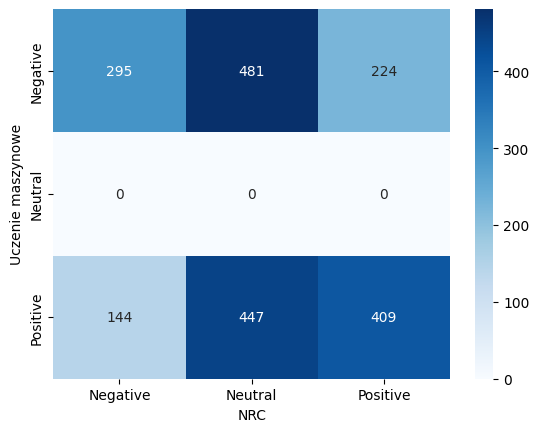

              precision    recall  f1-score   support

           0       0.67      0.29      0.41      1000
           2       0.00      0.00      0.00         0
           4       0.65      0.41      0.50      1000

    accuracy                           0.35      2000
   macro avg       0.44      0.23      0.30      2000
weighted avg       0.66      0.35      0.46      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [ ]:
cm = confusion_matrix(df_daneNRC['target'], df_daneNRC['nrc_sentiment'])
print("Macierz pomyłek:\n", cm)

# Wizualizacja macierzy
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('NRC')
plt.ylabel('Uczenie maszynowe')
plt.show()

# Szczegółowy raport klasyfikacji
print(classification_report(df_daneNRC['target'], df_daneNRC['nrc_sentiment']))

## Dominujące emocje

Najczęstsze słowa występujące w tekstach przypisanych do konkretnej emocji i osobne wykresy słupkowe dla każdej emocji dominującej wpisy.

In [ ]:
def get_top_emotion(emotion_dict):
    if not emotion_dict:
        return None
    return max(emotion_dict.items(), key=lambda x: x[1])[0]

df_daneNRC['dominant_emotion'] = df_daneNRC['emotions'].apply(get_top_emotion)


In [ ]:
# Słownik emocji → lista słów
emotion_words = {}

for emotion in df_daneNRC['dominant_emotion'].dropna().unique():
    # Wybierz teksty z daną emocją
    texts = df_daneNRC[df_daneNRC['dominant_emotion'] == emotion]['text_lemmatized']

    # Tokenizuj i zlicz słowa
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)

    # Zachowaj 10 najczęstszych
    emotion_words[emotion] = word_counts.most_common(10)

/tmp/ipython-input-97-2538309074.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




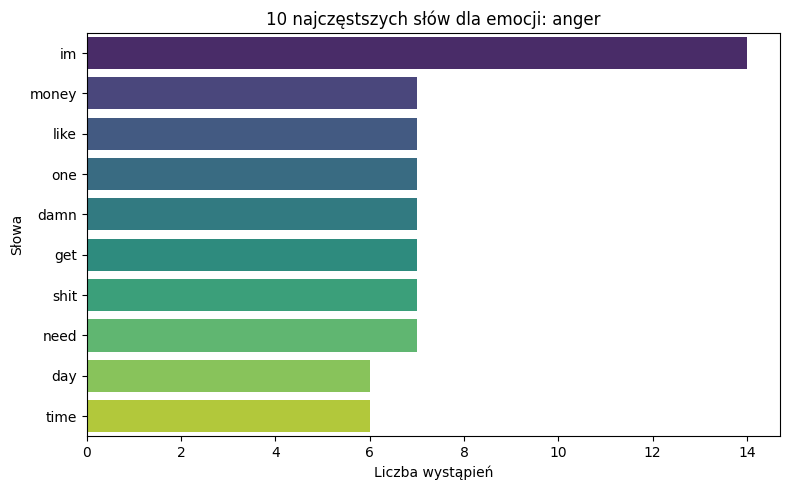

/tmp/ipython-input-97-2538309074.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




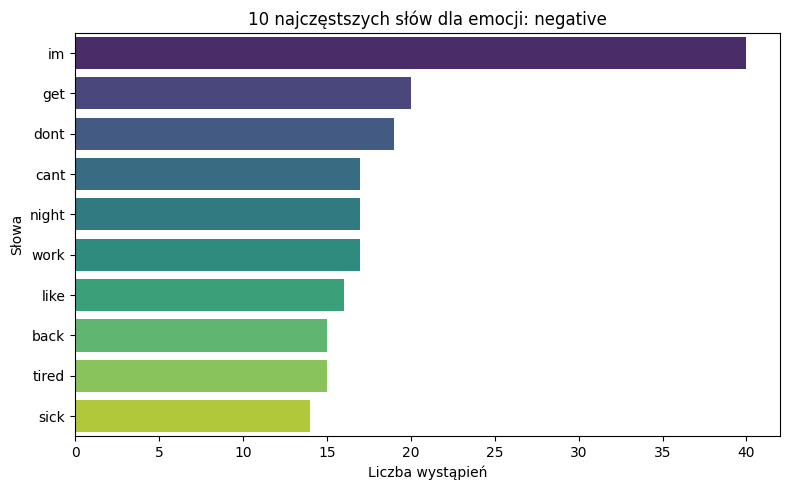

/tmp/ipython-input-97-2538309074.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




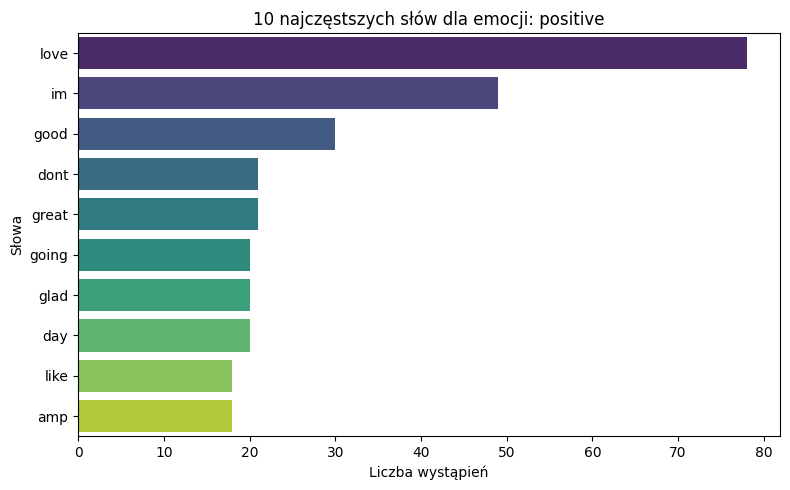

/tmp/ipython-input-97-2538309074.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




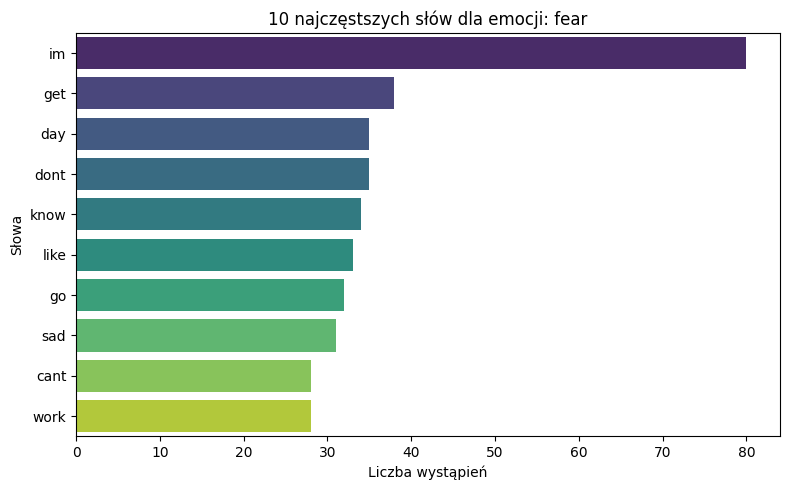

/tmp/ipython-input-97-2538309074.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




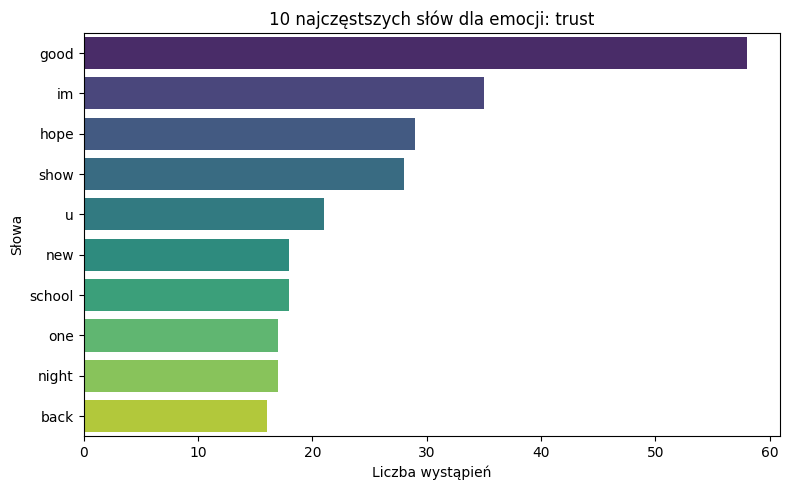

/tmp/ipython-input-97-2538309074.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




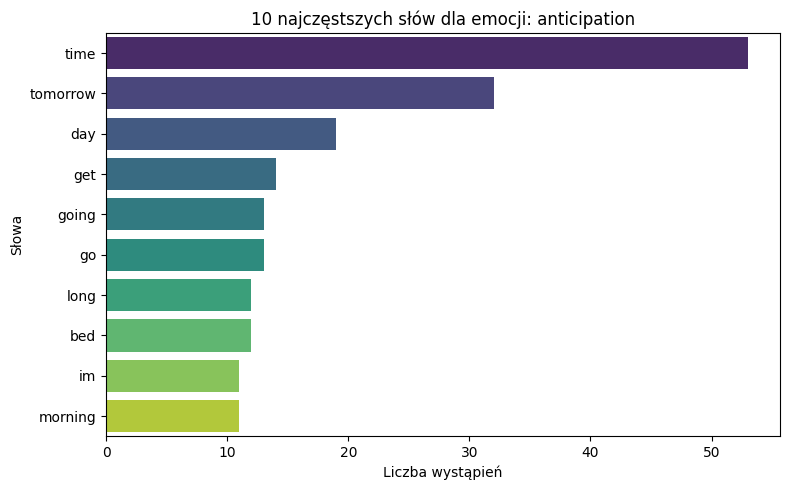

/tmp/ipython-input-97-2538309074.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




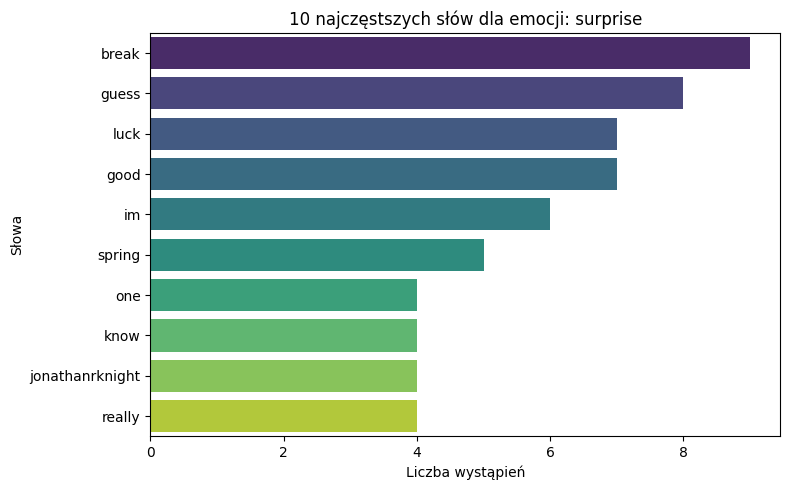

/tmp/ipython-input-97-2538309074.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




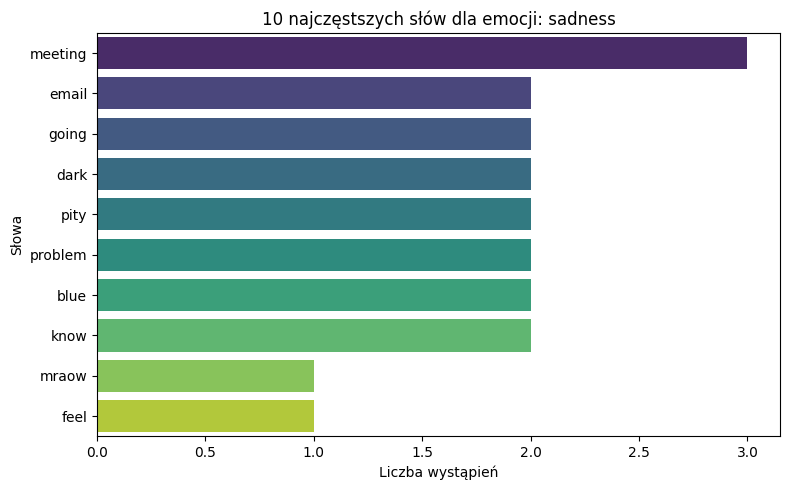

/tmp/ipython-input-97-2538309074.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




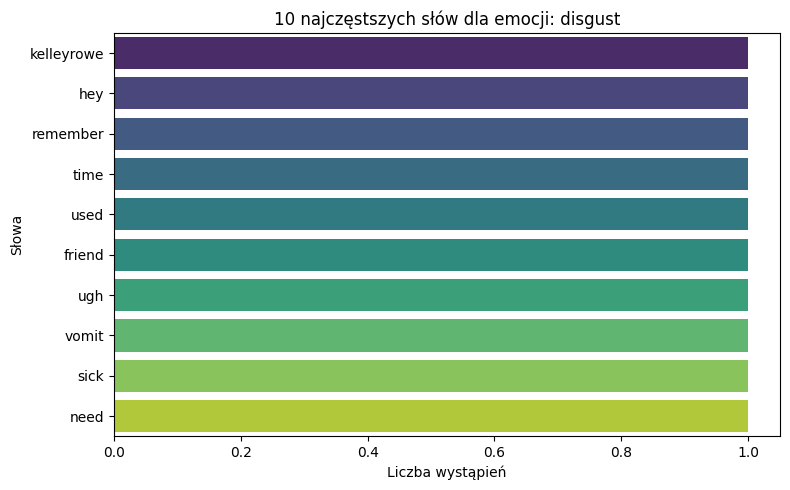

In [ ]:
for emotion, words in emotion_words.items():
    labels, counts = zip(*words)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(counts), y=list(labels), palette="viridis")
    plt.title(f"10 najczęstszych słów dla emocji: {emotion}")
    plt.xlabel("Liczba wystąpień")
    plt.ylabel("Słowa")
    plt.tight_layout()
    plt.show()

In [ ]:
all_nrc_emotions = {'anger', 'anticipation', 'disgust', 'fear', 'joy',
                    'sadness', 'surprise', 'trust', 'positive', 'negative'}

found_emotions = set(df_daneNRC['dominant_emotion'].dropna().unique())

missing = all_nrc_emotions - found_emotions
print("Brakujące emocje:", missing)

Brakujące emocje: {'joy'}


Brakuje joy, to znaczy, że żaden tekst w zbiorze nie miał joy jako dominującej emocji według NRCLex. To że joy się pojawiło oznacza, że joy nie jest dominującą w żadnym wierszu.

Poniższe wykresy pokazują każde wystąpienie każdej emocji, dlatego powstał wykres dla joy.

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




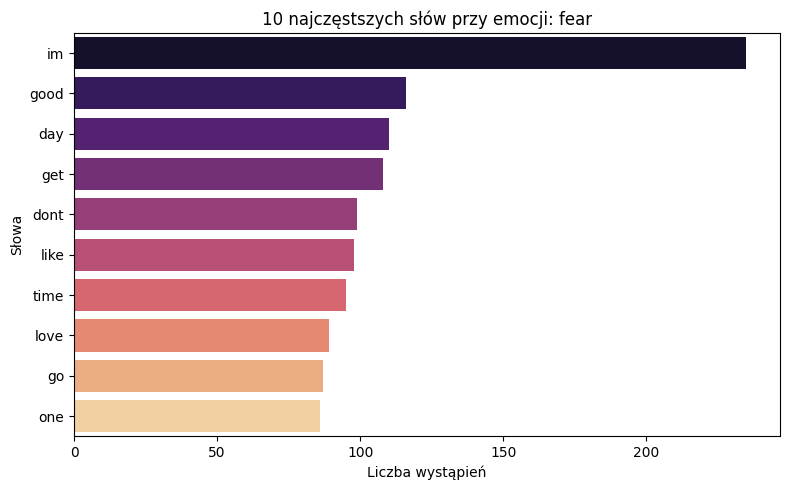

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




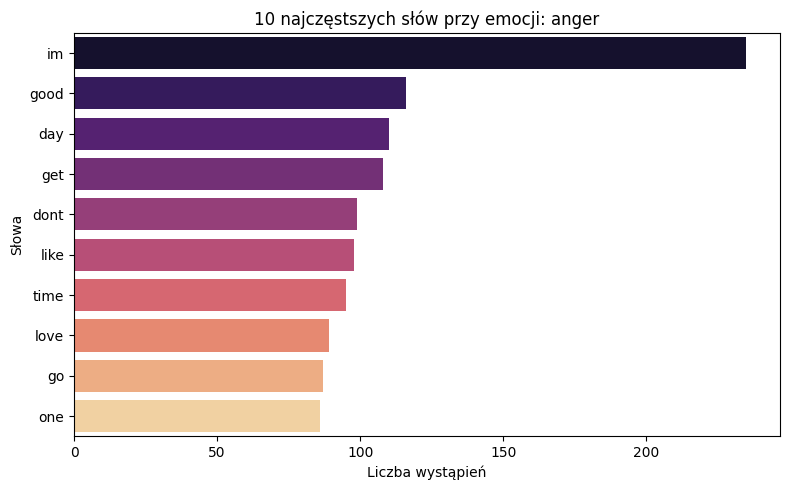

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




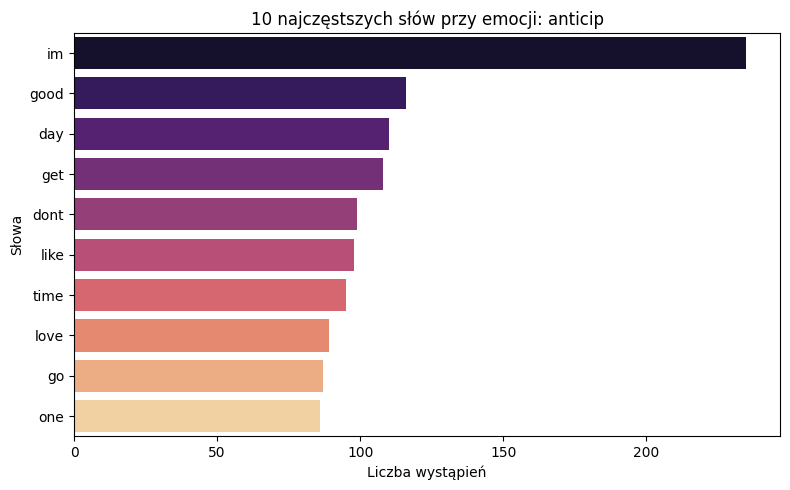

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




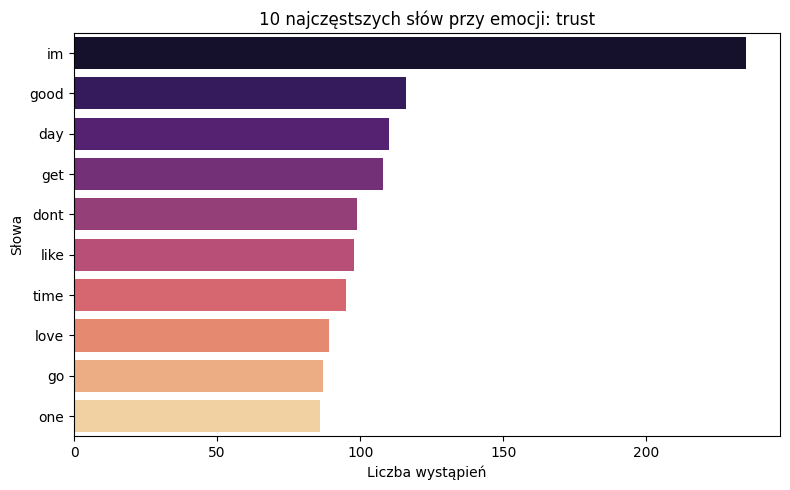

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




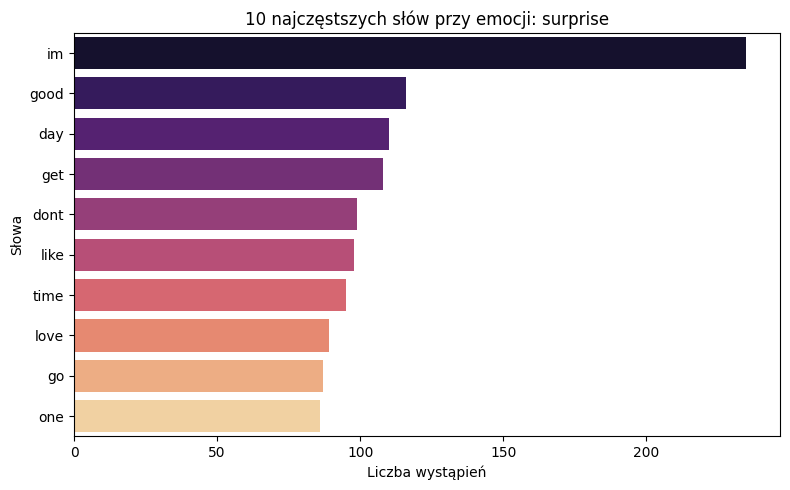

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




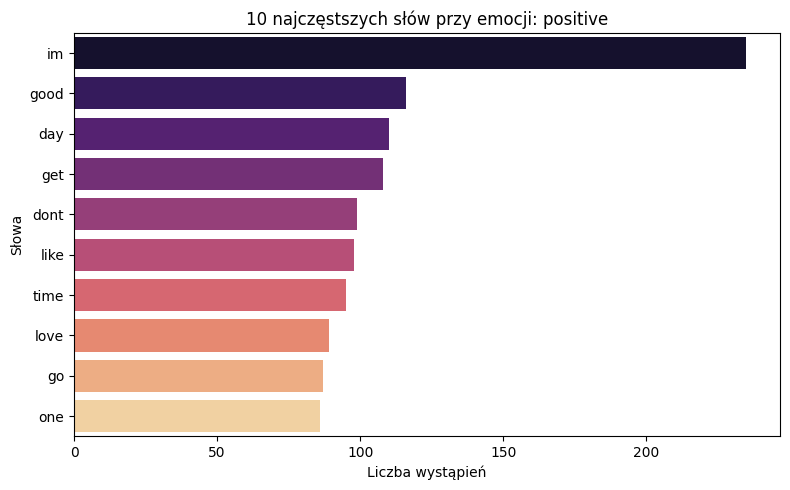

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




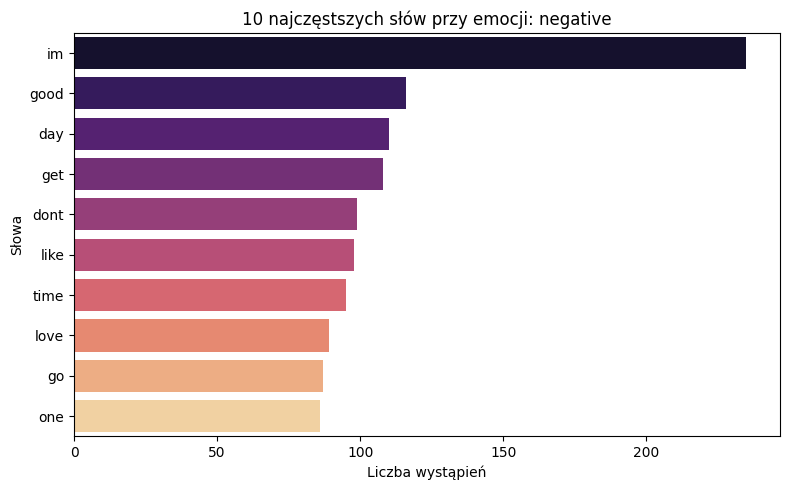

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




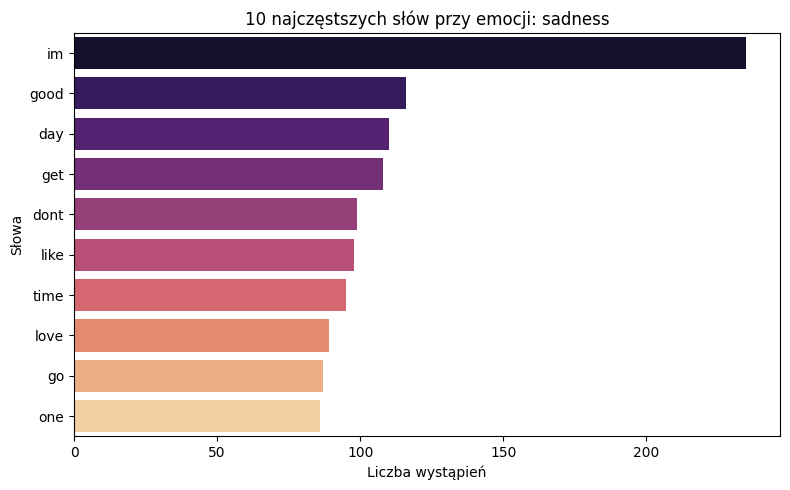

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




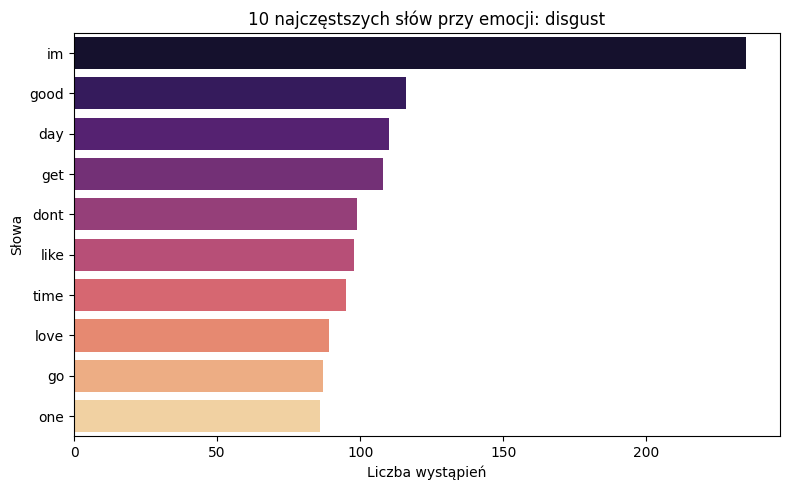

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




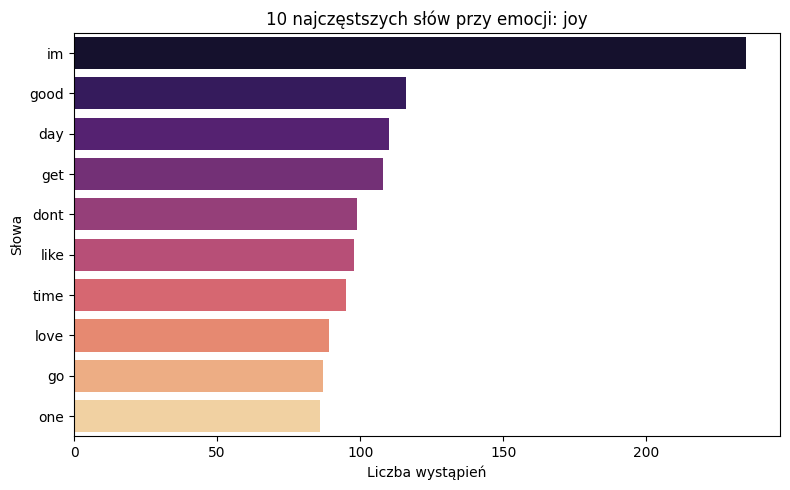

/tmp/ipython-input-99-2877871259.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




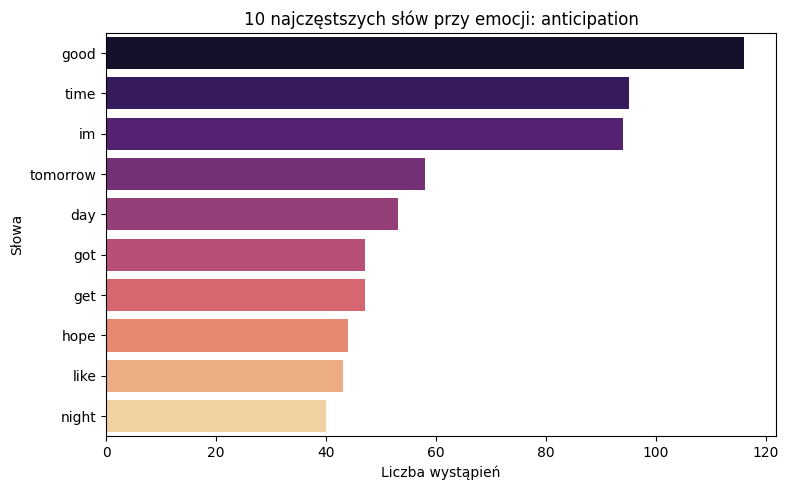

In [ ]:
from collections import defaultdict

# Słownik emocja → lista słów
emotion_word_counts = defaultdict(Counter)

for _, row in df_daneNRC.iterrows():
    text = row['text_lemmatized']
    words = text.split()
    emotions = row['emotions']

    for emotion in emotions:
        emotion_word_counts[emotion].update(words)

# Pokazanie wykresów
for emotion, word_counter in emotion_word_counts.items():
    top_words = word_counter.most_common(10)
    labels, counts = zip(*top_words)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(counts), y=list(labels), palette="magma")
    plt.title(f"10 najczęstszych słów przy emocji: {emotion}")
    plt.xlabel("Liczba wystąpień")
    plt.ylabel("Słowa")
    plt.tight_layout()
    plt.show()

## Rozkład emocji

Powstała wcześniej przez błąd błędna etykieta anticp, więc dodałem jej wartości do anticipation i ją usunąłem.

In [ ]:
def clean_emotions(raw_emotions):
    corrected = {}
    for k, v in raw_emotions.items():
        if k == 'anticip':
            corrected['anticipation'] = corrected.get('anticipation', 0) + v
        else:
            corrected[k] = corrected.get(k, 0) + v
    return corrected

df_daneNRC['emotions'] = df_daneNRC['text_lemmatized'].apply(lambda x: clean_emotions(NRCLex(x).raw_emotion_scores))


In [ ]:
# Sprawdź, czy 'anticip' istnieje
if 'anticip' in emotion_totals:
    # Dodaj wartość z 'anticip' do poprawnej etykiety
    emotion_totals['anticipation'] += emotion_totals['anticip']

    # Usuń błędną etykietę
    del emotion_totals['anticip']

In [ ]:
# Lista poprawnych etykiet NRC
nrc_labels = {'anger', 'anticipation', 'disgust', 'fear', 'joy',
              'sadness', 'surprise', 'trust', 'positive', 'negative'}

# Sprawdź, czy są jakieś nieprawidłowe klucze
invalid_keys = set(emotion_totals.keys()) - nrc_labels
print("Nieprawidłowe etykiety emocji:", invalid_keys)

Nieprawidłowe etykiety emocji: set()


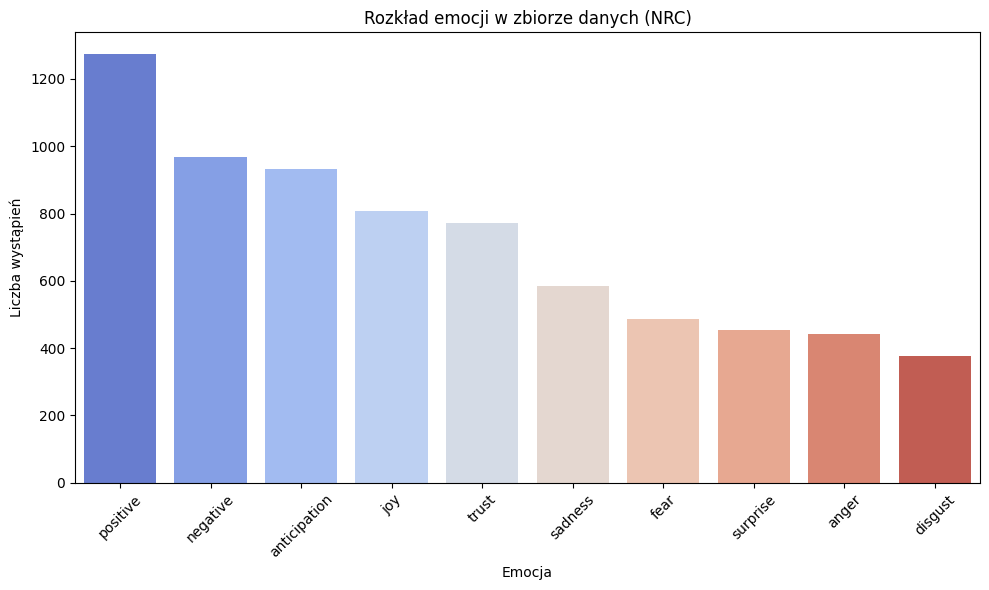

        emotion  count
7      positive   1275
2      negative    968
4  anticipation    931
6           joy    808
5         trust    771
3       sadness    585
8          fear    487
9      surprise    453
0         anger    442
1       disgust    377


In [171]:
# Sumowanie wszystkich emocji
emotion_totals = Counter()

for emo_dict in df_daneNRC['emotions']:
    emotion_totals.update(emo_dict)

#  dataframe
emotion_df = pd.DataFrame(emotion_totals.items(), columns=['emotion', 'count']).sort_values(by='count', ascending=False)

# Wykres
plt.figure(figsize=(10, 6))
sns.barplot(data=emotion_df, x='emotion', y='count', palette='coolwarm')
plt.title("Rozkład emocji w zbiorze danych (NRC)")
plt.ylabel("Liczba wystąpień")
plt.xlabel("Emocja")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Wyświetlenie tabeli
print(emotion_df)

## Tabela częstości emocji

In [ ]:
# Sumowanie emocji
emotion_totals = Counter()
for emo_dict in df_daneNRC['emotions']:
    emotion_totals.update(emo_dict)

# dataframe
emotion_freq_df = pd.DataFrame.from_dict(emotion_totals, orient='index', columns=['count'])

# Posortuj malejąco
emotion_freq_df = emotion_freq_df.sort_values(by='count', ascending=False)

# Reset indeksu i nazwij kolumny
emotion_freq_df = emotion_freq_df.reset_index().rename(columns={'index': 'emotion'})

# wynik
print(emotion_freq_df)

        emotion  count
0      positive   1275
1      negative    968
2  anticipation    931
3           joy    808
4         trust    771
5       sadness    585
6          fear    487
7      surprise    453
8         anger    442
9       disgust    377


## Współwystępowanie emocji

In [ ]:
# Lista unikalnych emocji w całym zbiorze
all_emotions = set()
for emo_dict in df_daneNRC['emotions']:
    all_emotions.update(emo_dict.keys())
all_emotions = sorted(all_emotions)

# Pusta macierz
co_occurrence = pd.DataFrame(0, index=all_emotions, columns=all_emotions)

# macierz współwystępowania
for emo_dict in df_daneNRC['emotions']:
    emotions_present = [emo for emo, val in emo_dict.items() if val > 0]
    for e1, e2 in combinations(emotions_present, 2):
        co_occurrence.loc[e1, e2] += 1
        co_occurrence.loc[e2, e1] += 1
    # Zwiększ licznik na przekątnej (własne wystąpienie)
    for e in emotions_present:
        co_occurrence.loc[e, e] += 1

# Wyświetl macierz
print(co_occurrence)

              anger  anticipation  disgust  fear  joy  negative  positive  \
anger           383           174      243   273  154       371       197   
anticipation    174           718      151   181  484       299       545   
disgust         243           151      339   208  134       325       178   
fear            273           181      208   407  154       366       200   
joy             154           484      134   154  641       255       637   
negative        371           299      325   366  255       724       348   
positive        197           545      178   200  637       348       870   
sadness         279           205      237   316  185       465       252   
surprise        123           328      105   126  334       170       344   
trust           143           443      128   152  481       238       539   

              sadness  surprise  trust  
anger             279       123    143  
anticipation      205       328    443  
disgust           237       1

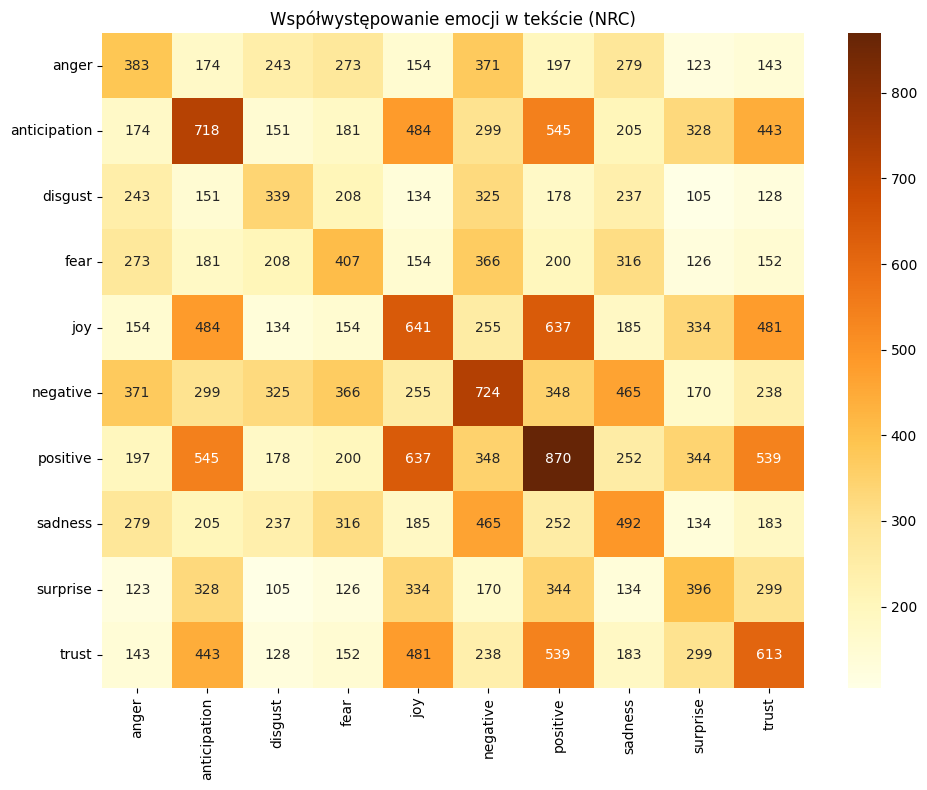

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence, cmap="YlOrBr", annot=True, fmt='d')
plt.title("Współwystępowanie emocji w tekście (NRC)")
plt.tight_layout()
plt.show()

## Klasteryzacja emocjonalna użytkowników

Czyli pogrupujemy użytkowników według dominujących emocji w ich wypowiedziach, np. użytkownicy, u których przeważa anger, joy, itp. Nie potrzebnie usunąłem wcześniej kolumny date i users, muszę je teraz dodać z powrotem.

In [ ]:
DATASET_COLUMNS2 = ["target", "ids", "date", "flag", "user", "text"]
df_klasteryzacja = pd.read_csv('drive/MyDrive/training.1600000.processed.noemoticon.csv',
                 encoding = DATASET_ENCODING, names=DATASET_COLUMNS2)

df_klasteryzacja = df_klasteryzacja[['target','ids','date','user']]
df_klasteryzacja.head()

,target,ids,date,user
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli


In [ ]:
df_merged = df_daneNRC.merge(df_klasteryzacja[['ids', 'user', 'date']], on='ids', how='left')
df_merged.head()

,target,ids,text_lemmatized,nrc_sentiment,fear,anger,anticip,trust,surprise,positive,negative,sadness,disgust,joy,anticipation,emotions,dominant_emotion,user,date
0,0,1467810369,switchfoot awww thats bummer shoulda got david...,0,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.333333,0.000000,0.333333,0.000000,NaN,"{'anger': 1, 'disgust': 1, 'negative': 1}",anger,_TheSpecialOne_,Mon Apr 06 22:19:45 PDT 2009
1,0,1467810672,upset cant update facebook texting might cry r...,0,0.0,0.142857,0.0,0.142857,0.0,0.000000,0.285714,0.285714,0.000000,0.000000,0.142857,"{'anger': 1, 'negative': 2, 'sadness': 2, 'ant...",negative,scotthamilton,Mon Apr 06 22:19:49 PDT 2009
2,0,1467810917,kenichan dived many time ball managed save 50 ...,4,0.0,0.000000,0.0,0.166667,0.0,0.333333,0.166667,0.000000,0.000000,0.166667,0.166667,"{'anticipation': 1, 'joy': 1, 'positive': 2, '...",positive,mattycus,Mon Apr 06 22:19:53 PDT 2009
3,0,1467811184,whole body feel itchy like fire,2,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,{'fear': 1},fear,ElleCTF,Mon Apr 06 22:19:57 PDT 2009
4,0,1467811193,nationwideclass behaving im mad cant see,0,0.2,0.200000,0.0,0.000000,0.0,0.000000,0.200000,0.200000,0.200000,0.000000,NaN,"{'anger': 1, 'disgust': 1, 'fear': 1, 'negativ...",fear,Karoli,Mon Apr 06 22:19:57 PDT 2009


Możemy teraz zsumować emocje na każdego użytkownika.

In [ ]:
# Tworzymy słownik: użytkownik -> suma emocji
user_emotion_totals = defaultdict(lambda: defaultdict(int))

for _, row in df_merged.iterrows():
    user = row['user']
    for emotion, score in row['emotions'].items():
        user_emotion_totals[user][emotion] += score

# Konwersja do DataFrame
user_emotion_df = pd.DataFrame.from_dict(user_emotion_totals, orient='index').fillna(0)

# Dodaj dominującą emocję
user_emotion_df['dominant_emotion'] = user_emotion_df.idxmax(axis=1)

user_emotion_df.head()

,anger,disgust,negative,sadness,anticipation,trust,joy,positive,fear,surprise,dominant_emotion
_TheSpecialOne_,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,anger
scotthamilton,1.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,negative
Karoli,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,anger
TLeC,2.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0,fear
bayofwolves,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,anger


Możemy też policzyć ilu użytkowników ma każdą dominującą emocję.

/tmp/ipython-input-129-1413048825.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




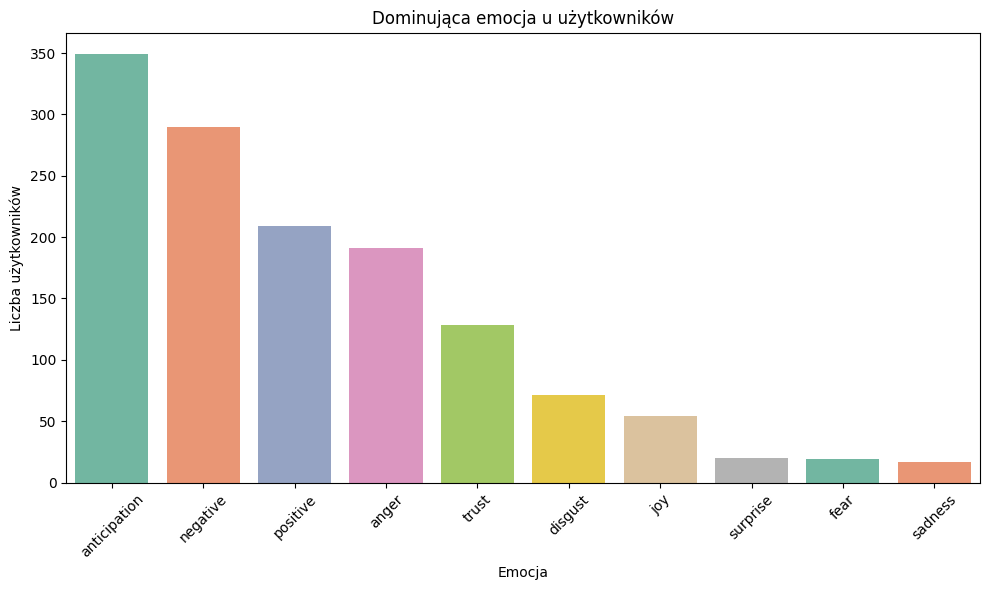

In [ ]:
emotion_counts = user_emotion_df['dominant_emotion'].value_counts()

# Wykres
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='Set2')
plt.title('Dominująca emocja u użytkowników')
plt.xlabel('Emocja')
plt.ylabel('Liczba użytkowników')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Klasteryzacja używająca KMeans

In [ ]:
# Przygotowanie danyc
X = user_emotion_df.drop(columns=['dominant_emotion'])

# Standaryzacja (ważne dla KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Klasteryzacja
kmeans = KMeans(n_clusters=5, random_state=42)
user_emotion_df['cluster'] = kmeans.fit_predict(X_scaled)

# wynik
user_emotion_df[['dominant_emotion', 'cluster']].head()

,dominant_emotion,cluster
_TheSpecialOne_,anger,0
scotthamilton,negative,4
Karoli,anger,4
TLeC,fear,4
bayofwolves,anger,0


## Wykres liniowy emocji

Dataset na niestandardowy format daty, który zawiera skróty dni i miesięcy oraz ma zapisaną strefę czasową PDT, czyli Pacific Time zone. Dane trzeba przefarsować.

In [ ]:
# Funkcja do parsowania z ignorowaniem strefy czasowej

def parse_date_remove_tz(x):
    try:
        parts = x.split()
        # usuń przedostatni token, jeśli to strefa czasowa
        if parts[-2] in ['PDT', 'PST', 'EDT', 'EST', 'CDT', 'CST', 'MDT', 'MST']:
            parts.pop(-2)
        new_date_str = ' '.join(parts)
        return parser.parse(new_date_str)
    except:
        return pd.NaT

df_merged['date_parsed'] = df_merged['date'].apply(parse_date_remove_tz)

# sprawdź efekt
print(df_merged[['date', 'date_parsed']].head())
df_merged['date_only'] = df_merged['date_parsed'].dt.date

                 date date_parsed
0 2009-04-06 22:19:45         NaT
1 2009-04-06 22:19:49         NaT
2 2009-04-06 22:19:53         NaT
3 2009-04-06 22:19:57         NaT
4 2009-04-06 22:19:57         NaT


In [ ]:
# agregacja emocji
emotion_cols = ['joy', 'anger', 'fear', 'sadness', 'trust', 'disgust', 'surprise', 'anticipation', 'positive', 'negative']
df_time = df_merged.groupby('date')[emotion_cols].sum().reset_index()

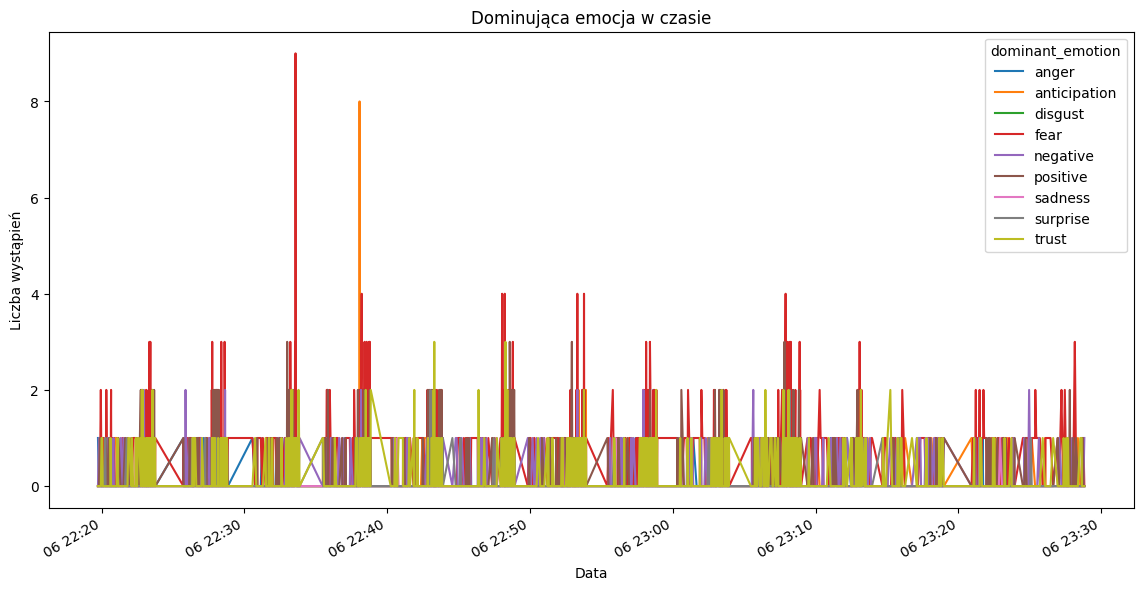

In [ ]:
df_counts = df_merged.groupby(['date', 'dominant_emotion']).size().unstack(fill_value=0)
df_counts.plot(figsize=(14,7))
plt.title('Dominująca emocja w czasie')
plt.xlabel('Data')
plt.ylabel('Liczba wystąpień')
plt.show()

Dataset został zrobiony z danych zebranych tylko z tych okresów:
- Mon Jun 15 12:53:14 PDT 2009
- Mon Jun 15 13:39:50 PDT 2009
- Fri May 22 05:10:17 PDT 2009
- Fri May 29 13:40:04 PDT 2009
- Fri Jun 05 11:05:33 PDT 2009